Импортируем нужные библиотеки.

In [30]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from catboost import CatBoostClassifier

Распакуйте архив с данными в папку,где находится этот jupyter notebook (baseline.ipynb). У вас будет папка data,  содержащая необходимые файлы. 

Ваша задача предсказать вероятность совершения покупки Клиентом в определенных 8 категориях в следующие 7 дней, чтобы под них Банк смог направить релевантный контент (подборки). Для подготовки предсказания у вас есть данные по транзакциям 50 000 Клиентов в течение года, из которых 25 000 – в обучающей выборке и 25 000 – в тестовой. Ваша задача для тестовой выборки рассчитать для каждой из целевой категории вероятность совершения покупки в ней на следующей неделе.

Данные по транзакциям находятся в файле **transactions_train.csv**. Информация о покупках по категориям для исследуемой недели находится в файле **train_target.csv**.

Считаем данные по транзакциям и правильные ответы.

In [31]:
transactions_train = pd.read_csv('transactions_train.csv')
train_target = pd.read_csv('train_target.csv')
transactions_test = pd.read_csv('transactions_test.csv')
test_id = pd.read_csv('test.csv')

In [32]:
def get_amount_features(transactions, name):
    amount_cat = transactions.groupby(['client_dk','small_group']).sum()['amount']
    amount_cat = amount_cat.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')
    amount_cat = amount_cat.fillna(0)
    amount_cat.columns = [name + str(i) for i in amount_cat.columns]
    return amount_cat

def get_count_features(transactions, name):
    counter_df = transactions.groupby(['client_dk','small_group'])['amount'].count()
    cat_counts = counter_df.reset_index().pivot(index='client_dk', \
                                                      columns='small_group',values='amount')
    cat_counts = cat_counts.fillna(0)
    cat_counts.columns = [name + str(i) for i in cat_counts.columns]
    return cat_counts


def get_features(transactions, target):
    agg_features = transactions.groupby('client_dk')['amount'].agg(['mean','max','min','std','sum','count']).reset_index()
    
    count_cat = get_count_features(transactions, 'cat_count_')
    amount_cat = get_amount_features(transactions, 'cat_spend_')
    
    count_cat_norm = get_count_features(transactions[(transactions.amount >= 100) & (transactions.amount <= 1500)], 'cat_count_norm_')
    amount_cat_norm = get_amount_features(transactions[(transactions.amount >= 100) & (transactions.amount <= 1500)], 'cat_spend_norm_')
    
    amount_cat_last_week = get_amount_features(transactions[transactions.trans_date > 380], 'cat_spend_last_week_')
    count_cat_last_week = get_count_features(transactions[transactions.trans_date > 380], 'cat_count_last_week_')  
    
    amount_cat_last_3days = get_amount_features(transactions[transactions.trans_date > 384], 'cat_spend_last_3days_')
    count_cat_last_3days = get_count_features(transactions[transactions.trans_date > 384], 'cat_count_last_3days_')  
    
    amount_cat_last_2weeks = get_amount_features(transactions[transactions.trans_date > 373], 'cat_spend_last_2weeks_')
    count_cat_last_2weeks = get_count_features(transactions[transactions.trans_date > 373], 'cat_count_last_2weeks_')   
    
    amount_cat_last_month = get_amount_features(transactions[transactions.trans_date > 357], 'cat_spend_last_month_')
    count_cat_last_month = get_count_features(transactions[transactions.trans_date > 357], 'cat_count_last_month_')    
    
    amount_cat_sport_peak = get_amount_features(transactions[(transactions.trans_date >= 283) & (transactions.trans_date <= 300)], 'cat_spend_sport_peak_')
    count_cat_sport_peak = get_count_features(transactions[(transactions.trans_date >= 283) & (transactions.trans_date <= 300)], 'cat_count_sport_peak_')    
    
    amount_cat_flower_peak = get_amount_features(transactions[(transactions.trans_date >= 126) & (transactions.trans_date <= 127)], 'cat_spend_flower_peak_')
    count_cat_flower_peak = get_count_features(transactions[(transactions.trans_date >= 126) & (transactions.trans_date <= 127)], 'cat_count_flower_peak_')    
    
    amount_cat_week_year_ago = get_amount_features(transactions[(transactions.trans_date >= 333) & (transactions.trans_date <= 339)], 'cat_spend_week_year_ago_')
    count_cat_week_year_ago = get_count_features(transactions[(transactions.trans_date >= 333) & (transactions.trans_date <= 339)], 'cat_count_week_year_ago_')   
    
    out = pd.merge(target, agg_features, on='client_dk', how='outer')
    out = pd.merge(out, count_cat.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_last_week.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_last_week.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_last_3days.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_last_3days.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_last_2weeks.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_last_2weeks.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_last_month.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_last_month.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_sport_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_sport_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_flower_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_flower_peak.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, count_cat_week_year_ago.reset_index(), on='client_dk', how='outer')
    out = pd.merge(out, amount_cat_week_year_ago.reset_index(), on='client_dk', how='outer')
    
    return out

In [33]:
train = get_features(transactions_train, train_target)

In [34]:
test = get_features(transactions_test, test_id[['client_dk']])

In [40]:
common_features = list(set(test.columns).intersection(set(train.columns)))
cf = []
for i in common_features:
    if "cat" in i:
        if int(i.split("_")[-1]) < 100:
            cf.append(i)
    else:
        cf.append(i)

In [41]:
common_features = cf

In [42]:
X_train = train[common_features]
X_test = test[common_features]

In [43]:
X_train

,cat_count_flower_peak_38,cat_spend_sport_peak_92,cat_count_sport_peak_70,cat_count_11,cat_count_last_3days_8,cat_spend_flower_peak_22,cat_count_last_2weeks_87,cat_count_week_year_ago_56,cat_count_flower_peak_26,cat_count_last_3days_79,...,cat_count_last_week_10,cat_spend_last_2weeks_85,cat_spend_sport_peak_53,cat_spend_27,cat_count_67,cat_count_last_month_89,cat_spend_11,cat_count_last_3days_73,cat_count_sport_peak_21,cat_count_last_2weeks_7
0,0.0,0.0,0.0,18.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,830.118,0.0,0.0,173.193,0.0,0.0,0.0
1,0.0,0.0,0.0,97.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,29.005,0.0,0.0,4093.074,0.0,0.0,1.0
2,0.0,0.0,0.0,73.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,1723.636,0.0,0.0,0.0
3,0.0,0.0,0.0,42.0,0.0,0.000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,5747.665,0.0,0.0,0.0
4,0.0,0.0,0.0,11.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,84.698,0.0,0.0,120.283,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.0,0.0,0.0,72.0,0.0,6.865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,1.0,0.0,4359.951,0.0,0.0,0.0
24996,0.0,0.0,0.0,59.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2547.828,0.0,1.0,2091.840,0.0,0.0,0.0
24997,NaN,0.0,0.0,28.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,52.962,0.0,0.0,602.372,0.0,0.0,1.0
24998,0.0,0.0,0.0,79.0,0.0,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000,0.0,0.0,14035.365,0.0,0.0,0.0


В этом бэйзлайне мы будем использовать простой подход - предсказывать покупки в каждой категории независимо. То есть в цикле модель обучается на отдельную категорию как на зависимую переменную, и пытается предсказать наличие покупки в этой определенной категории для теста. В итоге у нас получается 8 задач бинарной классификации.

**Важно**: Такой подход не претендует на звание лучшего, вы вольны придумать свой алгоритм решения, который, вполне вероятно, окажется лучше.

In [44]:
params = {
    'n_estimators': 1000,
    'depth': 6,
    'random_state':42,
    'learning_rate': 0.027,
    'eval_metric': 'AUC',
    'loss_function': 'MultiClass',
    'verbose': 1000, 
    
}

In [45]:
#В словарь будем записывать предсказания модели
results_tree = {}
main_result = [] 
#Цикл со второго элемента, потому что первой колонкой идет идентификатор клиента 
for q in train_target.columns[1:]:
    print('train product '+str(q))
    curr_target_train = train_target.loc[:,q]
    model = CatBoostClassifier(**params)
    #model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train.fillna(0).values,curr_target_train.values)
    main_result.append(model.get_evals_result())
    #Сделаем предсказание
    pred = model.predict_proba(X_test.fillna(0).values)[:,1]
    results_tree[q] = pred

train product 27
0:	total: 246ms	remaining: 4m 6s
999:	total: 3m 44s	remaining: 0us
train product 32
0:	total: 289ms	remaining: 4m 48s
999:	total: 4m 15s	remaining: 0us
train product 41
0:	total: 311ms	remaining: 5m 10s
999:	total: 4m 10s	remaining: 0us
train product 45
0:	total: 288ms	remaining: 4m 47s
999:	total: 4m 14s	remaining: 0us
train product 67
0:	total: 271ms	remaining: 4m 30s
999:	total: 3m 56s	remaining: 0us
train product 73
0:	total: 261ms	remaining: 4m 20s
999:	total: 4m 5s	remaining: 0us
train product 81
0:	total: 266ms	remaining: 4m 25s
999:	total: 3m 58s	remaining: 0us
train product 88
0:	total: 269ms	remaining: 4m 28s
999:	total: 3m 59s	remaining: 0us


Такое решение дает на публичном лидерборде качество 0.6023

### Подготовим файл для отправки в систему

In [46]:
submission = pd.DataFrame(data=np.zeros((25000,8)),columns=train_target.columns[1:],index=test_id['client_dk'].values)

In [47]:
for q in results_tree:
    submission[q] = results_tree[q]
submission.columns = ['cat_27','cat_32','cat_41','cat_45','cat_67','cat_73','cat_81','cat_88']

In [48]:
submission.index.name = 'client_dk'

Сохраняем прогноз на диск в папку submissions. Имя прогноза соответсвует дате и времени его создания, закодированными с помощью timestamp.

In [49]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
submission.to_csv(submission_path, index=True)

submissions/1583500578.csv


Теперь все готово! Можно отправлять решение.

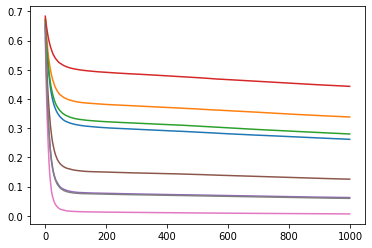

In [17]:
import matplotlib.pyplot as plt
plt.plot(main_result[0]['learn']['Logloss']) #27.Спортивные мероприятия - синий
plt.plot(main_result[1]['learn']['Logloss']) # 32. Театр - оранжевый
plt.plot(main_result[2]['learn']['Logloss']) # 41.Ночной клуб - зеленый
plt.plot(main_result[3]['learn']['Logloss']) # 45.Кинотеатры - красный
plt.plot(main_result[4]['learn']['Logloss']) # 67.Доставка еды - фиолетовый светлый
plt.plot(main_result[5]['learn']['Logloss']) # 73.Выставки - фиолетовый темный
plt.plot(main_result[6]['learn']['Logloss']) # 81.Билеты на спортивные мероприятия - розовый
plt.plot(main_result[7]['learn']['Logloss']) # 88.Цирк - черный

In [ ]:
plt.plot(main_result[1]['learn']['MultiClass']) #32.Театр


In [ ]:
plt.plot(main_result[2]['learn']['MultiClass']) #33. Ночные клубы